In [29]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import logging

In [76]:
from rules_related import combine_rules_outputs
from whole_algorithm import train_model
from auxiliary import calc_log_returns
from multivariate_normal_distribution import LongMultivariateNormal
from model import FuzzyVolatilityModel
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

In [3]:
with open('config.json') as file:
    config = json.load(file)

In [4]:
files_folder = config['files_folders']['processed']

# RTS

## Reading files

In [5]:
rtsi = pd.read_pickle(f'{files_folder}/rtsi.pkl')

In [6]:
rtsi

,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<VOL>,return,log return
<DATE>,,,,,,,
2001-02-18,180.10,180.10,180.10,180.10,0,0.000000,0.000000
2001-02-19,180.10,181.21,176.67,177.29,0,-0.015602,-0.015725
2001-02-20,177.29,179.90,175.28,176.45,0,-0.004738,-0.004749
2001-02-21,176.45,176.45,161.12,162.39,0,-0.079683,-0.083037
2001-02-22,162.39,168.35,162.39,168.31,0,0.036455,0.035807
...,...,...,...,...,...,...,...
2021-10-11,1871.73,1883.71,1867.58,1882.43,1769145502,0.011537,0.011471
2021-10-12,1867.15,1876.79,1860.64,1869.94,1386130631,-0.006635,-0.006657
2021-10-13,1869.05,1869.05,1835.80,1855.11,1830447018,-0.007931,-0.007962


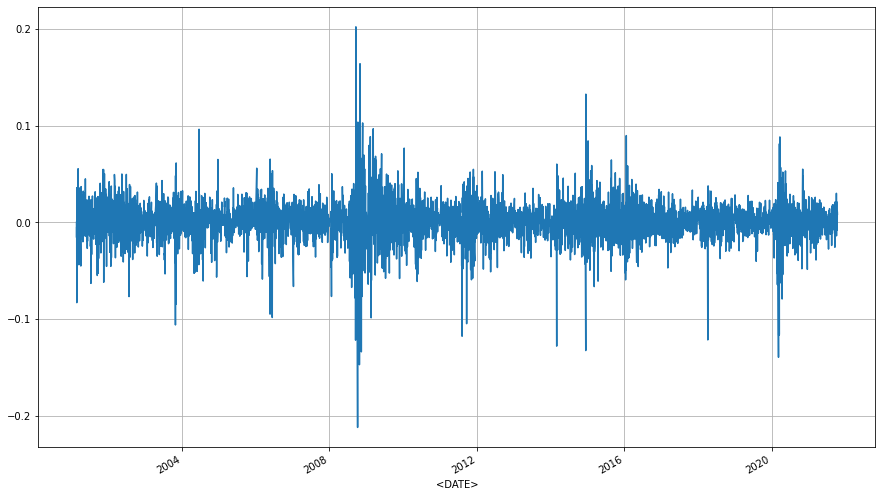

In [7]:
rtsi['log return'].plot(figsize=(15, 9))

plt.grid()
plt.show()

In [8]:
rtsi['log return'].describe()

count    5174.000000
mean        0.000455
std         0.020327
min        -0.211994
25%        -0.008822
50%         0.001318
75%         0.010414
max         0.202039
Name: log return, dtype: float64

## Looking at data

## Modeling

### Setting data

In [9]:
rescale_factor = 100

In [56]:
start_date = '2020-01-01'

In [57]:
input_data = rtsi['log return'].loc[start_date:].copy() * rescale_factor

In [58]:
n = input_data.shape[0]

In [59]:
n

452

In [60]:
input_data.describe()

count    452.000000
mean       0.044213
std        2.065685
min      -13.948614
25%       -0.832806
50%        0.209539
75%        0.996702
max        8.825149
Name: log return, dtype: float64

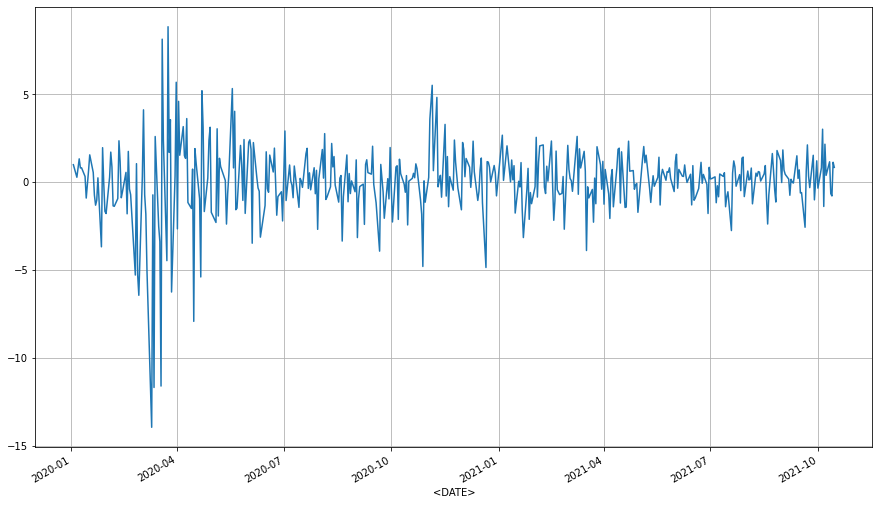

In [61]:
input_data.plot(figsize=(15, 9))

plt.grid()
plt.show()

### Setting local method parameters

In [62]:
clusterization_method = 'gaussian'
local_method = 'garch'
local_method_parameters = {'p': 1, 'q': 1, 'mean': 'Zero', 'dist': 'normal'}

### train & test split 

In [88]:
# n_train = 2000
# n_test = n - n_train

n_test = 100
n_train = n - n_test

In [89]:
train, test = input_data.iloc[:n_train].copy(), input_data.iloc[n_train:].copy()

In [100]:
train.describe()

count    352.000000
mean       0.010139
std        2.278209
min      -13.948614
25%       -0.910323
50%        0.199096
75%        1.126712
max        8.825149
Name: log return, dtype: float64

### 2 clusters

#### setting clusterization parameters

In [101]:
n_clusters = 2

# mu = 0
sigma = 1

centers = [2, 10]  # np.array([[mu] * n])
variances = [2, 2]  # np.array([np.diag([sigma] * n, k=0)])

clusterization_parameters = {'centers': centers, 'variances': variances, 'n_clusters': n_clusters}

#### Running model

In [102]:
logging.basicConfig(level=logging.DEBUG)

In [103]:
fvm = FuzzyVolatilityModel(train,
                           clusterization_method=clusterization_method,
                           clusterization_parameters=clusterization_parameters,
                           local_method=local_method,
                           local_method_parameters=local_method_parameters)

INFO:model.FuzzyVolatilityModel:Creating an instance of FuzzyVolatilityModel


##### fitting

In [104]:
fvm.fit()

DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting
DEBUG:pdf:log_pdf = -1249.3435002600668, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -1249.3435002600668, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:pdf:log_pdf = -9683.067322046876, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -9683.067322046876, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [2, 10], 'variances': [2, 2], 'n_clusters': 2}
Membership degrees:
[2.61223254e-0543 4.98074305e-4206]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed


Iteration:      1,   Func. Count:      5,   Neg. LLF: 182593544.0063408
Iteration:      2,   Func. Count:     11,   Neg. LLF: 813.1511170092414
Iteration:      3,   Func. Count:     18,   Neg. LLF: 875.8189469644826
Iteration:      4,   Func. Count:     24,   Neg. LLF: 716.6794418458932
Iteration:      5,   Func. Count:     28,   Neg. LLF: 716.6323676252414
Iteration:      6,   Func. Count:     32,   Neg. LLF: 716.6176972463879
Iteration:      7,   Func. Count:     36,   Neg. LLF: 716.6174190069044
Iteration:      8,   Func. Count:     40,   Neg. LLF: 716.6174150866752
Iteration:      9,   Func. Count:     43,   Neg. LLF: 716.6174150864063
Optimization terminated successfully    (Exit mode 0)
            Current function value: 716.6174150866752
            Iterations: 9
            Function evaluations: 43
            Gradient evaluations: 9
Iteration:      1,   Func. Count:      5,   Neg. LLF: 182593544.0063408
Iteration:      2,   Func. Count:     11,   Neg. LLF: 813.1511170092414
I

##### testing

In [105]:
%%time

fvm.feed_daily_data(test)

DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.4034367911124699, 1.4034367911124699]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.4034367911124699
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting
DEBUG:pdf:log_pdf = -1252.2287035421732, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -1252.2287035421732, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:pdf:log_pdf = -9712.133892336993, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -9712.133892336993, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clust

Iteration:      1,   Func. Count:      5,   Neg. LLF: 182738769.65439907
Iteration:      2,   Func. Count:     11,   Neg. LLF: 781.8276351919606
Iteration:      3,   Func. Count:     18,   Neg. LLF: 721.5991742919307
Iteration:      4,   Func. Count:     23,   Neg. LLF: 717.8300514210603
Iteration:      5,   Func. Count:     27,   Neg. LLF: 717.9942352233809
Iteration:      6,   Func. Count:     32,   Neg. LLF: 717.809315080993
Iteration:      7,   Func. Count:     36,   Neg. LLF: 717.8092890105784
Iteration:      8,   Func. Count:     39,   Neg. LLF: 717.8092890098435
Optimization terminated successfully    (Exit mode 0)
            Current function value: 717.8092890105784
            Iterations: 8
            Function evaluations: 39
            Gradient evaluations: 8
Iteration:      1,   Func. Count:      5,   Neg. LLF: 182738769.65439907
Iteration:      2,   Func. Count:     11,   Neg. LLF: 781.8276351919606
Iteration:      3,   Func. Count:     18,   Neg. LLF: 721.5991742919307


DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.4477347596285597, 1.4477347596285597]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.4477347596285597
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting
DEBUG:pdf:log_pdf = -1254.9859961932148, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -1254.9859961932148, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:pdf:log_pdf = -9751.99654115739, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -9751.99654115739, type


Iteration:      2,   Func. Count:     11,   Neg. LLF: 781.3066466085402
Iteration:      3,   Func. Count:     18,   Neg. LLF: 724.3584326061828
Iteration:      4,   Func. Count:     23,   Neg. LLF: 720.1223901487142
Iteration:      5,   Func. Count:     28,   Neg. LLF: 719.3909384551861
Iteration:      6,   Func. Count:     32,   Neg. LLF: 719.3674309501855
Iteration:      7,   Func. Count:     36,   Neg. LLF: 719.3673355535883
Iteration:      8,   Func. Count:     40,   Neg. LLF: 719.3673347080271
Optimization terminated successfully    (Exit mode 0)
            Current function value: 719.3673347080271
            Iterations: 8
            Function evaluations: 40
            Gradient evaluations: 8
Iteration:      1,   Func. Count:      5,   Neg. LLF: 184651042.6560586
Iteration:      2,   Func. Count:     11,   Neg. LLF: 819.7932867243742
Iteration:      3,   Func. Count:     18,   Neg. LLF: 880.9577880803027
Iteration:      4,   Func. Count:     24,   Neg. LLF: 721.3637101220088


DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.6742226717179032, 1.6742226717179032]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.6742226717179032
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting
DEBUG:pdf:log_pdf = -1257.6406357645062, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -1257.6406357645062, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:pdf:log_pdf = -9780.080080805556, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -9780.080080805556, ty

Iteration:      2,   Func. Count:     11,   Neg. LLF: 819.7932867243742
Iteration:      3,   Func. Count:     18,   Neg. LLF: 880.9577880803027
Iteration:      4,   Func. Count:     24,   Neg. LLF: 721.3637101220088
Iteration:      5,   Func. Count:     28,   Neg. LLF: 721.3386970620255
Iteration:      6,   Func. Count:     32,   Neg. LLF: 721.3258250908286
Iteration:      7,   Func. Count:     36,   Neg. LLF: 721.3257353092573
Iteration:      8,   Func. Count:     40,   Neg. LLF: 721.3257324503339
Iteration:      9,   Func. Count:     43,   Neg. LLF: 721.3257324498309
Optimization terminated successfully    (Exit mode 0)
            Current function value: 721.3257324503339
            Iterations: 9
            Function evaluations: 43
            Gradient evaluations: 9
Iteration:      1,   Func. Count:      5,   Neg. LLF: 184709604.99379885
Iteration:      2,   Func. Count:     11,   Neg. LLF: 781.7104336397579
Iteration:      3,   Func. Count:     18,   Neg. LLF: 736.6385356099108


DEBUG:pdf:log_pdf = -9802.918139384617, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -9802.918139384617, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [2, 10], 'variances': [2, 2], 'n_clusters': 2}
Membership degrees:
[1.21210181e-0547 4.43348778e-4258]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.5206289157344928, 1.5206289157344928]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.5206289157344928
DEBUG:model.FuzzyVolatilityModel:Starting clusterizat

Iteration:      1,   Func. Count:      5,   Neg. LLF: 184954419.78901434
Iteration:      2,   Func. Count:     11,   Neg. LLF: 804.1331359297237
Iteration:      3,   Func. Count:     17,   Neg. LLF: 725.8819999339946
Iteration:      4,   Func. Count:     23,   Neg. LLF: 742.201782827581
Iteration:      5,   Func. Count:     28,   Neg. LLF: 723.8434613921095
Iteration:      6,   Func. Count:     32,   Neg. LLF: 723.8415303306333
Iteration:      7,   Func. Count:     36,   Neg. LLF: 723.8413907953228
Iteration:      8,   Func. Count:     40,   Neg. LLF: 723.8413812658823
Iteration:      9,   Func. Count:     43,   Neg. LLF: 723.841381266541
Optimization terminated successfully    (Exit mode 0)
            Current function value: 723.8413812658823
            Iterations: 9
            Function evaluations: 43
            Gradient evaluations: 9
Iteration:      1,   Func. Count:      5,   Neg. LLF: 184954419.78901434
Iteration:      2,   Func. Count:     11,   Neg. LLF: 804.1331359297237
I

DEBUG:pdf:log_pdf = -1263.263967180951, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -1263.263967180951, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:pdf:log_pdf = -9852.300535719627, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -9852.300535719627, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [2, 10], 'variances': [2, 2], 'n_clusters': 2}
Membership degrees:
[2.35195965e-0549 1.58578127e-4279]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.3435055174028392, 1.3435055174028392]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_out

Iteration:      1,   Func. Count:      5,   Neg. LLF: 185059606.40535533
Iteration:      2,   Func. Count:     11,   Neg. LLF: 878.2199101127194
Iteration:      3,   Func. Count:     17,   Neg. LLF: 827.8354718032498
Iteration:      4,   Func. Count:     23,   Neg. LLF: 726.1322853587159
Iteration:      5,   Func. Count:     27,   Neg. LLF: 726.1303027190761
Iteration:      6,   Func. Count:     31,   Neg. LLF: 726.1302735967483
Iteration:      7,   Func. Count:     34,   Neg. LLF: 726.1302735964949
Optimization terminated successfully    (Exit mode 0)
            Current function value: 726.1302735967483
            Iterations: 7
            Function evaluations: 34
            Gradient evaluations: 7
Iteration:      1,   Func. Count:      5,   Neg. LLF: 185059606.40535533
Iteration:      2,   Func. Count:     11,   Neg. LLF: 878.2199101127194
Iteration:      3,   Func. Count:     17,   Neg. LLF: 827.8354718032498
Iteration:      4,   Func. Count:     23,   Neg. LLF: 726.1322853587159

DEBUG:pdf:log_pdf = -1266.7131715699832, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -1266.7131715699832, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:pdf:log_pdf = -9898.340266761257, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -9898.340266761257, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [2, 10], 'variances': [2, 2], 'n_clusters': 2}
Membership degrees:
[7.47238832e-0551 1.60487845e-4299]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.301571568589004, 1.301571568589004]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_out

Iteration:      1,   Func. Count:      5,   Neg. LLF: 185663556.91536254
Iteration:      2,   Func. Count:     11,   Neg. LLF: 880.8016982030996
Iteration:      3,   Func. Count:     17,   Neg. LLF: 831.3025663833771
Iteration:      4,   Func. Count:     23,   Neg. LLF: 728.6754873439014
Iteration:      5,   Func. Count:     27,   Neg. LLF: 728.6735602594011
Iteration:      6,   Func. Count:     31,   Neg. LLF: 728.6735225593997
Iteration:      7,   Func. Count:     34,   Neg. LLF: 728.6735225585846
Optimization terminated successfully    (Exit mode 0)
            Current function value: 728.6735225593997
            Iterations: 7
            Function evaluations: 34
            Gradient evaluations: 7
Iteration:      1,   Func. Count:      5,   Neg. LLF: 185663556.91536254
Iteration:      2,   Func. Count:     11,   Neg. LLF: 880.8016982030996
Iteration:      3,   Func. Count:     17,   Neg. LLF: 831.3025663833771
Iteration:      4,   Func. Count:     23,   Neg. LLF: 728.6754873439014

DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting
DEBUG:pdf:log_pdf = -1270.8835563555785, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -1270.8835563555785, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:pdf:log_pdf = -9948.875405973495, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -9948.875405973495, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [2, 10], 'variances': [2, 2], 'n_clusters': 2}
Membership degrees:
[1.15420867e-0552 1.81263367e-4321]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Ru

Iteration:      1,   Func. Count:      5,   Neg. LLF: 185783671.65121275
Iteration:      2,   Func. Count:     11,   Neg. LLF: 882.0877391254138
Iteration:      3,   Func. Count:     17,   Neg. LLF: 783.590182517223
Iteration:      4,   Func. Count:     24,   Neg. LLF: 730.8102846600483
Iteration:      5,   Func. Count:     28,   Neg. LLF: 730.8100971542146
Iteration:      6,   Func. Count:     32,   Neg. LLF: 730.8100934906932
Iteration:      7,   Func. Count:     35,   Neg. LLF: 730.8100934915062
Optimization terminated successfully    (Exit mode 0)
            Current function value: 730.8100934906932
            Iterations: 7
            Function evaluations: 35
            Gradient evaluations: 7
Iteration:      1,   Func. Count:      5,   Neg. LLF: 185783671.65121275
Iteration:      2,   Func. Count:     11,   Neg. LLF: 882.0877391254138
Iteration:      3,   Func. Count:     17,   Neg. LLF: 783.590182517223
Iteration:      4,   Func. Count:     24,   Neg. LLF: 730.8102846600483
I

INFO:calc_gaussian_membership_degrees:Starting
DEBUG:pdf:log_pdf = -1276.4334830004682, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -1276.4334830004682, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:pdf:log_pdf = -10003.936750240167, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -10003.936750240167, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [2, 10], 'variances': [2, 2], 'n_clusters': 2}
Membership degrees:
[4.48726602e-0555 2.21550157e-4345]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.3336065926404337, 1.3336065926404337]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all r

Iteration:      1,   Func. Count:      5,   Neg. LLF: 187420611.1724471
Iteration:      2,   Func. Count:     11,   Neg. LLF: 886.4483474466049
Iteration:      3,   Func. Count:     17,   Neg. LLF: 838.8367878788232
Iteration:      4,   Func. Count:     24,   Neg. LLF: 733.9208761390465
Iteration:      5,   Func. Count:     28,   Neg. LLF: 733.9196134011072
Iteration:      6,   Func. Count:     32,   Neg. LLF: 733.9195917515736
Iteration:      7,   Func. Count:     35,   Neg. LLF: 733.9195917526923
Optimization terminated successfully    (Exit mode 0)
            Current function value: 733.9195917515736
            Iterations: 7
            Function evaluations: 35
            Gradient evaluations: 7
Iteration:      1,   Func. Count:      5,   Neg. LLF: 187420611.1724471
Iteration:      2,   Func. Count:     11,   Neg. LLF: 886.4483474466049
Iteration:      3,   Func. Count:     17,   Neg. LLF: 838.8367878788232
Iteration:      4,   Func. Count:     24,   Neg. LLF: 733.9208761390465
I

DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting
DEBUG:pdf:log_pdf = -1283.4182864775416, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -1283.4182864775416, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:pdf:log_pdf = -10066.79370315422, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -10066.79370315422, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [2, 10], 'variances': [2, 2], 'n_clusters': 2}
Membership degrees:
[4.15451383e-0558 1.11440810e-4372]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Ru

Iteration:      1,   Func. Count:      5,   Neg. LLF: 188590133.9096256
Iteration:      2,   Func. Count:     11,   Neg. LLF: 890.1644004599723
Iteration:      3,   Func. Count:     17,   Neg. LLF: 771.3992121415886
Iteration:      4,   Func. Count:     24,   Neg. LLF: 736.7801533980321
Iteration:      5,   Func. Count:     28,   Neg. LLF: 736.779088208658
Iteration:      6,   Func. Count:     32,   Neg. LLF: 736.7790675424872
Iteration:      7,   Func. Count:     35,   Neg. LLF: 736.7790675431123
Optimization terminated successfully    (Exit mode 0)
            Current function value: 736.7790675424872
            Iterations: 7
            Function evaluations: 35
            Gradient evaluations: 7
Iteration:      1,   Func. Count:      5,   Neg. LLF: 188590133.9096256
Iteration:      2,   Func. Count:     11,   Neg. LLF: 890.1644004599723
Iteration:      3,   Func. Count:     17,   Neg. LLF: 771.3992121415886
Iteration:      4,   Func. Count:     24,   Neg. LLF: 736.7801533980321
It

DEBUG:pdf:log_pdf = -1287.995348862807, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -1287.995348862807, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:pdf:log_pdf = -10119.259081168504, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -10119.259081168504, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [2, 10], 'variances': [2, 2], 'n_clusters': 2}
Membership degrees:
[4.27294470e-0560 1.82650178e-4395]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.2182123098904651, 1.2182123098904651]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_o

Iteration:      1,   Func. Count:      5,   Neg. LLF: 188771069.75695378
Iteration:      2,   Func. Count:     11,   Neg. LLF: 891.9830207284394
Iteration:      3,   Func. Count:     17,   Neg. LLF: 740.2829045729673
Iteration:      4,   Func. Count:     22,   Neg. LLF: 825.5313405776913
Iteration:      5,   Func. Count:     27,   Neg. LLF: 739.0137765343623
Iteration:      6,   Func. Count:     31,   Neg. LLF: 739.0136522919213
Iteration:      7,   Func. Count:     35,   Neg. LLF: 739.0136497756563
Iteration:      8,   Func. Count:     38,   Neg. LLF: 739.0136497754563
Optimization terminated successfully    (Exit mode 0)
            Current function value: 739.0136497756563
            Iterations: 8
            Function evaluations: 38
            Gradient evaluations: 8
Iteration:      1,   Func. Count:      5,   Neg. LLF: 188771069.75695378
Iteration:      2,   Func. Count:     11,   Neg. LLF: 891.9830207284394
Iteration:      3,   Func. Count:     17,   Neg. LLF: 740.2829045729673

DEBUG:pdf:log_pdf = -1291.7997499558337, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -1291.7997499558337, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:pdf:log_pdf = -10166.907280808071, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -10166.907280808071, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [2, 10], 'variances': [2, 2], 'n_clusters': 2}
Membership degrees:
[9.51692990e-0562 3.70058107e-4416]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.1934197323825737, 1.1934197323825737]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules

Iteration:      1,   Func. Count:      5,   Neg. LLF: 189593046.03229368
Iteration:      2,   Func. Count:     11,   Neg. LLF: 895.135588124408
Iteration:      3,   Func. Count:     17,   Neg. LLF: 742.8393966985752
Iteration:      4,   Func. Count:     22,   Neg. LLF: 871.2887528316937
Iteration:      5,   Func. Count:     27,   Neg. LLF: 741.5877058611405
Iteration:      6,   Func. Count:     31,   Neg. LLF: 741.5874622254377
Iteration:      7,   Func. Count:     35,   Neg. LLF: 741.5874579994911
Iteration:      8,   Func. Count:     38,   Neg. LLF: 741.5874579995385
Optimization terminated successfully    (Exit mode 0)
            Current function value: 741.5874579994911
            Iterations: 8
            Function evaluations: 38
            Gradient evaluations: 8
Iteration:      1,   Func. Count:      5,   Neg. LLF: 189593046.03229368
Iteration:      2,   Func. Count:     11,   Neg. LLF: 895.135588124408
Iteration:      3,   Func. Count:     17,   Neg. LLF: 742.8393966985752
I

DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.1247868340887892, 1.1247868340887892]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.1247868340887892
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting
DEBUG:pdf:log_pdf = -1296.0929330704203, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -1296.0929330704203, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:pdf:log_pdf = -10218.046532772038, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -10218.046532772038, 


Iteration:      8,   Func. Count:     38,   Neg. LLF: 742.6675390217918
Optimization terminated successfully    (Exit mode 0)
            Current function value: 742.6675390215307
            Iterations: 8
            Function evaluations: 38
            Gradient evaluations: 8
Iteration:      1,   Func. Count:      5,   Neg. LLF: 189730139.67939174
Iteration:      2,   Func. Count:     11,   Neg. LLF: 896.7386000773654
Iteration:      3,   Func. Count:     17,   Neg. LLF: 744.814580767764
Iteration:      4,   Func. Count:     22,   Neg. LLF: 771.8849211834698
Iteration:      5,   Func. Count:     27,   Neg. LLF: 743.6484824951453
Iteration:      6,   Func. Count:     31,   Neg. LLF: 743.6477269877234
Iteration:      7,   Func. Count:     35,   Neg. LLF: 743.647713412779
Iteration:      8,   Func. Count:     38,   Neg. LLF: 743.6477134132124
Optimization terminated successfully    (Exit mode 0)
            Current function value: 743.647713412779
            Iterations: 8
            

DEBUG:pdf:log_pdf = -10254.080104694624, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -10254.080104694624, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [2, 10], 'variances': [2, 2], 'n_clusters': 2}
Membership degrees:
[1.00564582e-0565 5.12381614e-4454]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.4119605000755777, 1.4119605000755777]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.4119605000755777
DEBUG:model.FuzzyVolatilityModel:Starting clusteriz

Iteration:      1,   Func. Count:      5,   Neg. LLF: 192139059.4744825
Iteration:      2,   Func. Count:     11,   Neg. LLF: 901.2001620932439
Iteration:      3,   Func. Count:     17,   Neg. LLF: 747.4950503845746
Iteration:      4,   Func. Count:     22,   Neg. LLF: 836.3827249078658
Iteration:      5,   Func. Count:     27,   Neg. LLF: 746.1047816211624
Iteration:      6,   Func. Count:     31,   Neg. LLF: 746.1046085870241
Iteration:      7,   Func. Count:     35,   Neg. LLF: 746.104604850774
Iteration:      8,   Func. Count:     38,   Neg. LLF: 746.1046048507297
Optimization terminated successfully    (Exit mode 0)
            Current function value: 746.104604850774
            Iterations: 8
            Function evaluations: 38
            Gradient evaluations: 8
Iteration:      1,   Func. Count:      5,   Neg. LLF: 192139059.4744825
Iteration:      2,   Func. Count:     11,   Neg. LLF: 901.2001620932439
Iteration:      3,   Func. Count:     17,   Neg. LLF: 747.4950503845746
Ite

DEBUG:pdf:log_pdf = -1304.6634435920937, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -1304.6634435920937, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:pdf:log_pdf = -10301.777270893544, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -10301.777270893544, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [2, 10], 'variances': [2, 2], 'n_clusters': 2}
Membership degrees:
[2.46527690e-0567 9.88501778e-4475]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.273287112293053, 1.273287112293053]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_o

Iteration:      1,   Func. Count:      5,   Neg. LLF: 192578965.31028733
Iteration:      2,   Func. Count:     11,   Neg. LLF: 904.0634661963878
Iteration:      3,   Func. Count:     17,   Neg. LLF: 749.91328913024
Iteration:      4,   Func. Count:     22,   Neg. LLF: 926.0054393578837
Iteration:      5,   Func. Count:     27,   Neg. LLF: 748.5287394214816
Iteration:      6,   Func. Count:     31,   Neg. LLF: 748.5283015010209
Iteration:      7,   Func. Count:     35,   Neg. LLF: 748.5282977674601
Iteration:      8,   Func. Count:     38,   Neg. LLF: 748.5282977678736
Optimization terminated successfully    (Exit mode 0)
            Current function value: 748.5282977674601
            Iterations: 8
            Function evaluations: 38
            Gradient evaluations: 8
Iteration:      1,   Func. Count:      5,   Neg. LLF: 192578965.31028733
Iteration:      2,   Func. Count:     11,   Neg. LLF: 904.0634661963878
Iteration:      3,   Func. Count:     17,   Neg. LLF: 749.91328913024
Ite

DEBUG:pdf:log_pdf = -1308.7462258081905, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -1308.7462258081905, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:pdf:log_pdf = -10351.947464706232, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -10351.947464706232, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [2, 10], 'variances': [2, 2], 'n_clusters': 2}
Membership degrees:
[4.15657786e-0569 1.60819655e-4496]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.091213559590246, 1.091213559590246]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_o

Iteration:      1,   Func. Count:      5,   Neg. LLF: 192660448.79552788
Iteration:      2,   Func. Count:     11,   Neg. LLF: 905.5915352905661
Iteration:      3,   Func. Count:     17,   Neg. LLF: 751.9794533305351
Iteration:      4,   Func. Count:     22,   Neg. LLF: 766.2982681192188
Iteration:      5,   Func. Count:     27,   Neg. LLF: 750.6101394765345
Iteration:      6,   Func. Count:     31,   Neg. LLF: 750.6084882049001
Iteration:      7,   Func. Count:     35,   Neg. LLF: 750.6084346150637
Iteration:      8,   Func. Count:     38,   Neg. LLF: 750.6084346154548
Optimization terminated successfully    (Exit mode 0)
            Current function value: 750.6084346150637
            Iterations: 8
            Function evaluations: 38
            Gradient evaluations: 8
Iteration:      1,   Func. Count:      5,   Neg. LLF: 192660448.79552788
Iteration:      2,   Func. Count:     11,   Neg. LLF: 905.5915352905661
Iteration:      3,   Func. Count:     17,   Neg. LLF: 751.9794533305351

INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.194779404618155
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting
DEBUG:pdf:log_pdf = -1315.0376711669364, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -1315.0376711669364, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:pdf:log_pdf = -10411.836148374156, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -10411.836148374156, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [2, 10], 'variances': [2, 2], 'n_clusters': 2}
Membership degrees:
[7.69831925e-0572 1.57403462e-4522]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 193715325.08975467
Iteration:      2,   Func. Count:     11,   Neg. LLF: 909.1121804463977
Iteration:      3,   Func. Count:     17,   Neg. LLF: 754.6522674842004
Iteration:      4,   Func. Count:     22,   Neg. LLF: 760.306502343644
Iteration:      5,   Func. Count:     27,   Neg. LLF: 753.2391169657615
Iteration:      6,   Func. Count:     31,   Neg. LLF: 753.2338887967476
Iteration:      7,   Func. Count:     35,   Neg. LLF: 753.2337732264002
Iteration:      8,   Func. Count:     38,   Neg. LLF: 753.2337732258416
Optimization terminated successfully    (Exit mode 0)
            Current function value: 753.2337732264002
            Iterations: 8
            Function evaluations: 38
            Gradient evaluations: 8
Iteration:      1,   Func. Count:      5,   Neg. LLF: 193715325.08975467
Iteration:      2,   Func. Count:     11,   Neg. LLF: 909.1121804463977
Iteration:      3,   Func. Count:     17,   Neg. LLF: 754.6522674842004


DEBUG:pdf:log_pdf = -1320.187270265428, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -1320.187270265428, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:pdf:log_pdf = -10466.543528263783, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -10466.543528263783, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [2, 10], 'variances': [2, 2], 'n_clusters': 2}
Membership degrees:
[4.46635711e-0574 2.74094976e-4546]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.042595563284579, 1.042595563284579]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_out

Iteration:      1,   Func. Count:      5,   Neg. LLF: 194383560.52773285
Iteration:      2,   Func. Count:     11,   Neg. LLF: 911.8619075488687
Iteration:      3,   Func. Count:     17,   Neg. LLF: 757.0435307691312
Iteration:      4,   Func. Count:     22,   Neg. LLF: 756.3671539030059
Iteration:      5,   Func. Count:     27,   Neg. LLF: 755.8509155064255
Iteration:      6,   Func. Count:     32,   Neg. LLF: 755.5823226678265
Iteration:      7,   Func. Count:     36,   Neg. LLF: 755.5822082607824
Iteration:      8,   Func. Count:     39,   Neg. LLF: 755.5822082605417
Optimization terminated successfully    (Exit mode 0)
            Current function value: 755.5822082607824
            Iterations: 8
            Function evaluations: 39
            Gradient evaluations: 8
Iteration:      1,   Func. Count:      5,   Neg. LLF: 194383560.52773285
Iteration:      2,   Func. Count:     11,   Neg. LLF: 911.8619075488687
Iteration:      3,   Func. Count:     17,   Neg. LLF: 757.0435307691312

DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [0.9669059197257595, 0.9669059197257595]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 0.9669059197257595
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting
DEBUG:pdf:log_pdf = -1323.9715202744574, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -1323.9715202744574, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:pdf:log_pdf = -10514.96588167841, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -10514.96588167841, ty

Iteration:      1,   Func. Count:      5,   Neg. LLF: 194459573.96367323
Iteration:      2,   Func. Count:     11,   Neg. LLF: 912.791460293121
Iteration:      3,   Func. Count:     17,   Neg. LLF: 758.060122886734
Iteration:      4,   Func. Count:     22,   Neg. LLF: 756.6046651907668
Iteration:      5,   Func. Count:     26,   Neg. LLF: 762.2436618769464
Iteration:      6,   Func. Count:     31,   Neg. LLF: 756.5663495858307
Iteration:      7,   Func. Count:     35,   Neg. LLF: 756.5645648914804
Iteration:      8,   Func. Count:     39,   Neg. LLF: 756.5645539641991
Iteration:      9,   Func. Count:     42,   Neg. LLF: 756.5645539641118
Optimization terminated successfully    (Exit mode 0)
            Current function value: 756.5645539641991
            Iterations: 9
            Function evaluations: 42
            Gradient evaluations: 9
Iteration:      1,   Func. Count:      5,   Neg. LLF: 194459573.96367323
Iteration:      2,   Func. Count:     11,   Neg. LLF: 912.791460293121
It

DEBUG:pdf:log_pdf = -1328.1424311682863, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -1328.1424311682863, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:pdf:log_pdf = -10548.77297683698, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -10548.77297683698, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [2, 10], 'variances': [2, 2], 'n_clusters': 2}
Membership degrees:
[1.56700709e-0577 5.32237303e-4582]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.126509821264769, 1.126509821264769]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_out

Iteration:      1,   Func. Count:      5,   Neg. LLF: 196324145.7805971
Iteration:      2,   Func. Count:     11,   Neg. LLF: 916.7588146555668
Iteration:      3,   Func. Count:     17,   Neg. LLF: 761.1604334243111
Iteration:      4,   Func. Count:     22,   Neg. LLF: 759.6257867526147
Iteration:      5,   Func. Count:     26,   Neg. LLF: 759.9181062018076
Iteration:      6,   Func. Count:     31,   Neg. LLF: 759.5989293199577
Iteration:      7,   Func. Count:     36,   Neg. LLF: 759.5500587554043
Iteration:      8,   Func. Count:     40,   Neg. LLF: 759.5500550737959
Iteration:      9,   Func. Count:     43,   Neg. LLF: 759.5500550740928
Optimization terminated successfully    (Exit mode 0)
            Current function value: 759.5500550737959
            Iterations: 9
            Function evaluations: 43
            Gradient evaluations: 9
Iteration:      1,   Func. Count:      5,   Neg. LLF: 196324145.7805971
Iteration:      2,   Func. Count:     11,   Neg. LLF: 916.7588146555668
I

DEBUG:pdf:log_pdf = -1334.3344654883613, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -1334.3344654883613, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:pdf:log_pdf = -10608.581929154025, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -10608.581929154025, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [2, 10], 'variances': [2, 2], 'n_clusters': 2}
Membership degrees:
[3.20556528e-0580 5.64166572e-4608]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.0667290857444693, 1.0667290857444693]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules

Iteration:      1,   Func. Count:      5,   Neg. LLF: 197071644.42439854
Iteration:      2,   Func. Count:     11,   Neg. LLF: 919.9002493206932
Iteration:      3,   Func. Count:     17,   Neg. LLF: 763.6830277727504
Iteration:      4,   Func. Count:     22,   Neg. LLF: 762.4301198888429
Iteration:      5,   Func. Count:     27,   Neg. LLF: 763.4380169974645
Iteration:      6,   Func. Count:     32,   Neg. LLF: 761.9589947756649
Iteration:      7,   Func. Count:     36,   Neg. LLF: 761.9585938901199
Iteration:      8,   Func. Count:     40,   Neg. LLF: 761.9585912682633
Iteration:      9,   Func. Count:     43,   Neg. LLF: 761.9585912679768
Optimization terminated successfully    (Exit mode 0)
            Current function value: 761.9585912682633
            Iterations: 9
            Function evaluations: 43
            Gradient evaluations: 9
Iteration:      1,   Func. Count:      5,   Neg. LLF: 197071644.42439854
Iteration:      2,   Func. Count:     11,   Neg. LLF: 919.9002493206932

DEBUG:pdf:log_pdf = -1343.0984331328818, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -1343.0984331328818, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:pdf:log_pdf = -10674.384945564885, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -10674.384945564885, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [2, 10], 'variances': [2, 2], 'n_clusters': 2}
Membership degrees:
[5.00912463e-0584 1.49114690e-4636]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.8269942437065263, 1.8269942437065263]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules

Iteration:      1,   Func. Count:      5,   Neg. LLF: 202926547.53541368
Iteration:      2,   Func. Count:     11,   Neg. LLF: 930.925656328611
Iteration:      3,   Func. Count:     17,   Neg. LLF: 769.2950081878222
Iteration:      4,   Func. Count:     22,   Neg. LLF: 877.3266472494861
Iteration:      5,   Func. Count:     27,   Neg. LLF: 767.6367480845128
Iteration:      6,   Func. Count:     31,   Neg. LLF: 767.6361750138077
Iteration:      7,   Func. Count:     35,   Neg. LLF: 767.6361651764042
Iteration:      8,   Func. Count:     38,   Neg. LLF: 767.6361651771233
Optimization terminated successfully    (Exit mode 0)
            Current function value: 767.6361651764042
            Iterations: 8
            Function evaluations: 38
            Gradient evaluations: 8
Iteration:      1,   Func. Count:      5,   Neg. LLF: 202926547.53541368
Iteration:      2,   Func. Count:     11,   Neg. LLF: 930.925656328611
Iteration:      3,   Func. Count:     17,   Neg. LLF: 769.2950081878222
I

DEBUG:pdf:log_pdf = -1346.119235009371, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -1346.119235009371, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:pdf:log_pdf = -10717.20595414396, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -10717.20595414396, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [2, 10], 'variances': [2, 2], 'n_clusters': 2}
Membership degrees:
[2.44255444e-0585 3.77218249e-4655]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.7459022715475219, 1.7459022715475219]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_out

Iteration:      1,   Func. Count:      5,   Neg. LLF: 203962366.45520887
Iteration:      2,   Func. Count:     11,   Neg. LLF: 934.942411045623
Iteration:      3,   Func. Count:     17,   Neg. LLF: 772.3662503757857
Iteration:      4,   Func. Count:     22,   Neg. LLF: 896.918306048123
Iteration:      5,   Func. Count:     27,   Neg. LLF: 770.6676181858825
Iteration:      6,   Func. Count:     31,   Neg. LLF: 770.6669032794495
Iteration:      7,   Func. Count:     35,   Neg. LLF: 770.6668861572947
Iteration:      8,   Func. Count:     38,   Neg. LLF: 770.6668861580861
Optimization terminated successfully    (Exit mode 0)
            Current function value: 770.6668861572947
            Iterations: 8
            Function evaluations: 38
            Gradient evaluations: 8
Iteration:      1,   Func. Count:      5,   Neg. LLF: 203962366.45520887
Iteration:      2,   Func. Count:     11,   Neg. LLF: 934.942411045623
Iteration:      3,   Func. Count:     17,   Neg. LLF: 772.3662503757857
It

DEBUG:pdf:log_pdf = -1350.5342399798976, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -1350.5342399798976, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:pdf:log_pdf = -10768.923953376443, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -10768.923953376443, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [2, 10], 'variances': [2, 2], 'n_clusters': 2}
Membership degrees:
[2.95414600e-0587 1.30542226e-4677]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.4781938063163116, 1.4781938063163116]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules

Iteration:      1,   Func. Count:      5,   Neg. LLF: 204079554.3648604
Iteration:      2,   Func. Count:     11,   Neg. LLF: 937.1628482752593
Iteration:      3,   Func. Count:     17,   Neg. LLF: 774.9138575636769
Iteration:      4,   Func. Count:     22,   Neg. LLF: 1011.3411213897912
Iteration:      5,   Func. Count:     27,   Neg. LLF: 773.0864318213021
Iteration:      6,   Func. Count:     31,   Neg. LLF: 773.0849116924262
Iteration:      7,   Func. Count:     35,   Neg. LLF: 773.08482972704
Iteration:      8,   Func. Count:     38,   Neg. LLF: 773.084829728143
Optimization terminated successfully    (Exit mode 0)
            Current function value: 773.08482972704
            Iterations: 8
            Function evaluations: 38
            Gradient evaluations: 8
Iteration:      1,   Func. Count:      5,   Neg. LLF: 204079554.3648604
Iteration:      2,   Func. Count:     11,   Neg. LLF: 937.1628482752593
Iteration:      3,   Func. Count:     17,   Neg. LLF: 774.9138575636769
Itera

DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.3838304164281428, 1.3838304164281428]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.3838304164281428
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting
DEBUG:pdf:log_pdf = -1354.7248226943088, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -1354.7248226943088, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:pdf:log_pdf = -10817.682254642023, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -10817.682254642023, 

Iteration:      6,   Func. Count:     31,   Neg. LLF: 774.2802165385331
Iteration:      7,   Func. Count:     35,   Neg. LLF: 774.2800846331813
Iteration:      8,   Func. Count:     38,   Neg. LLF: 774.2800846337636
Optimization terminated successfully    (Exit mode 0)
            Current function value: 774.2800846331813
            Iterations: 8
            Function evaluations: 38
            Gradient evaluations: 8
Iteration:      1,   Func. Count:      5,   Neg. LLF: 205236817.18725485
Iteration:      2,   Func. Count:     11,   Neg. LLF: 940.9294538881117
Iteration:      3,   Func. Count:     17,   Neg. LLF: 777.8763734574986
Iteration:      4,   Func. Count:     22,   Neg. LLF: 853.9542764634263
Iteration:      5,   Func. Count:     27,   Neg. LLF: 776.0234193573748
Iteration:      6,   Func. Count:     31,   Neg. LLF: 776.0214340389011
Iteration:      7,   Func. Count:     35,   Neg. LLF: 776.0213245018256
Iteration:      8,   Func. Count:     38,   Neg. LLF: 776.0213245028876


DEBUG:pdf:log_pdf = -10837.379552903743, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -10837.379552903743, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [2, 10], 'variances': [2, 2], 'n_clusters': 2}
Membership degrees:
[1.15754768e-0589 2.43143063e-4707]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.6006226819454434, 1.6006226819454434]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.6006226819454434
DEBUG:model.FuzzyVolatilityModel:Starting clusteriz

Iteration:      1,   Func. Count:      5,   Neg. LLF: 206292763.04838902
Iteration:      2,   Func. Count:     11,   Neg. LLF: 943.5758601252707
Iteration:      3,   Func. Count:     17,   Neg. LLF: 779.6259074034953
Iteration:      4,   Func. Count:     22,   Neg. LLF: 996.2970953495447
Iteration:      5,   Func. Count:     27,   Neg. LLF: 777.8115759335828
Iteration:      6,   Func. Count:     31,   Neg. LLF: 777.8101012657548
Iteration:      7,   Func. Count:     35,   Neg. LLF: 777.8100231648754
Iteration:      8,   Func. Count:     38,   Neg. LLF: 777.8100231659722
Optimization terminated successfully    (Exit mode 0)
            Current function value: 777.8100231648754
            Iterations: 8
            Function evaluations: 38
            Gradient evaluations: 8
Iteration:      1,   Func. Count:      5,   Neg. LLF: 206292763.04838902
Iteration:      2,   Func. Count:     11,   Neg. LLF: 943.5758601252707
Iteration:      3,   Func. Count:     17,   Neg. LLF: 779.6259074034953

DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.5432952067650128, 1.5432952067650128]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.5432952067650128
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting
DEBUG:pdf:log_pdf = -1361.0879012732062, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -1361.0879012732062, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:pdf:log_pdf = -10891.23382217707, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -10891.23382217707, ty

Iteration:      1,   Func. Count:      5,   Neg. LLF: 206831258.03724042
Iteration:      2,   Func. Count:     11,   Neg. LLF: 946.8138456985844
Iteration:      3,   Func. Count:     17,   Neg. LLF: 782.351221659475
Iteration:      4,   Func. Count:     22,   Neg. LLF: 804.8473129540896
Iteration:      5,   Func. Count:     27,   Neg. LLF: 780.4439392226408
Iteration:      6,   Func. Count:     31,   Neg. LLF: 780.4402181702317
Iteration:      7,   Func. Count:     35,   Neg. LLF: 780.4400605000067
Iteration:      8,   Func. Count:     38,   Neg. LLF: 780.4400605004696
Optimization terminated successfully    (Exit mode 0)
            Current function value: 780.4400605000067
            Iterations: 8
            Function evaluations: 38
            Gradient evaluations: 8
Iteration:      1,   Func. Count:      5,   Neg. LLF: 206831258.03724042
Iteration:      2,   Func. Count:     11,   Neg. LLF: 946.8138456985844
Iteration:      3,   Func. Count:     17,   Neg. LLF: 782.351221659475
I

DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.337280602939157
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting
DEBUG:pdf:log_pdf = -1365.3596360109018, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -1365.3596360109018, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:pdf:log_pdf = -10942.431140787441, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -10942.431140787441, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [2, 10], 'variances': [2, 2], 'n_clusters': 2}
Membership degrees:
[1.07607927e-0593 5.78811231e-4753]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:m

Iteration:      1,   Func. Count:      5,   Neg. LLF: 206851602.81378442
Iteration:      2,   Func. Count:     11,   Neg. LLF: 948.6783338059291
Iteration:      3,   Func. Count:     17,   Neg. LLF: 784.7053089822816
Iteration:      4,   Func. Count:     22,   Neg. LLF: 784.2473398150963
Iteration:      5,   Func. Count:     27,   Neg. LLF: 782.7457428097614
Iteration:      6,   Func. Count:     32,   Neg. LLF: 782.6209712191164
Iteration:      7,   Func. Count:     36,   Neg. LLF: 782.6208732024618
Iteration:      8,   Func. Count:     39,   Neg. LLF: 782.6208732024002
Optimization terminated successfully    (Exit mode 0)
            Current function value: 782.6208732024618
            Iterations: 8
            Function evaluations: 39
            Gradient evaluations: 8
Iteration:      1,   Func. Count:      5,   Neg. LLF: 206851602.81378442
Iteration:      2,   Func. Count:     11,   Neg. LLF: 948.6783338059291
Iteration:      3,   Func. Count:     17,   Neg. LLF: 784.7053089822816

DEBUG:pdf:log_pdf = -1370.8875800493504, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -1370.8875800493504, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:pdf:log_pdf = -10997.77506450595, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -10997.77506450595, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [2, 10], 'variances': [2, 2], 'n_clusters': 2}
Membership degrees:
[4.27650195e-0596 5.33305757e-4777]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.3011607865243109, 1.3011607865243109]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_o

Iteration:      1,   Func. Count:      5,   Neg. LLF: 208150932.28970397
Iteration:      2,   Func. Count:     11,   Neg. LLF: 952.3749111404319
Iteration:      3,   Func. Count:     17,   Neg. LLF: 787.6471661108226
Iteration:      4,   Func. Count:     22,   Neg. LLF: 787.1293737716
Iteration:      5,   Func. Count:     27,   Neg. LLF: 785.6983430099463
Iteration:      6,   Func. Count:     32,   Neg. LLF: 785.5504836948552
Iteration:      7,   Func. Count:     36,   Neg. LLF: 785.5503758532043
Iteration:      8,   Func. Count:     39,   Neg. LLF: 785.5503758531013
Optimization terminated successfully    (Exit mode 0)
            Current function value: 785.5503758532043
            Iterations: 8
            Function evaluations: 39
            Gradient evaluations: 8
Iteration:      1,   Func. Count:      5,   Neg. LLF: 208150932.28970397
Iteration:      2,   Func. Count:     11,   Neg. LLF: 952.3749111404319
Iteration:      3,   Func. Count:     17,   Neg. LLF: 787.6471661108226
It

DEBUG:pdf:log_pdf = -1374.6788764638602, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -1374.6788764638602, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:pdf:log_pdf = -11046.24860113467, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -11046.24860113467, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [2, 10], 'variances': [2, 2], 'n_clusters': 2}
Membership degrees:
[9.65049439e-0598 4.73354811e-4798]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.1401506420237821, 1.1401506420237821]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_o

Iteration:      1,   Func. Count:      5,   Neg. LLF: 208358766.02344477
Iteration:      2,   Func. Count:     11,   Neg. LLF: 954.7719790296501
Iteration:      3,   Func. Count:     17,   Neg. LLF: 790.0503002109808
Iteration:      4,   Func. Count:     22,   Neg. LLF: 787.8402480011707
Iteration:      5,   Func. Count:     26,   Neg. LLF: 793.0849804846077
Iteration:      6,   Func. Count:     31,   Neg. LLF: 787.7670727573329
Iteration:      7,   Func. Count:     35,   Neg. LLF: 787.758176428355
Iteration:      8,   Func. Count:     39,   Neg. LLF: 787.7581011737825
Iteration:      9,   Func. Count:     42,   Neg. LLF: 787.7581011739207
Optimization terminated successfully    (Exit mode 0)
            Current function value: 787.7581011737825
            Iterations: 9
            Function evaluations: 42
            Gradient evaluations: 9
Iteration:      1,   Func. Count:      5,   Neg. LLF: 208358766.02344477
Iteration:      2,   Func. Count:     11,   Neg. LLF: 954.7719790296501


DEBUG:pdf:log_pdf = -1378.223315683004, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -1378.223315683004, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:pdf:log_pdf = -11093.18191994592, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -11093.18191994592, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [2, 10], 'variances': [2, 2], 'n_clusters': 2}
Membership degrees:
[2.78752755e-0599 1.96022272e-4818]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.045385027090306, 1.045385027090306]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outpu

Iteration:      1,   Func. Count:      5,   Neg. LLF: 208784552.2276733
Iteration:      2,   Func. Count:     11,   Neg. LLF: 957.102920960857
Iteration:      3,   Func. Count:     17,   Neg. LLF: 792.4977905339706
Iteration:      4,   Func. Count:     22,   Neg. LLF: 790.6331913094341
Iteration:      5,   Func. Count:     27,   Neg. LLF: 790.8359513372043
Iteration:      6,   Func. Count:     32,   Neg. LLF: 790.0005689253127
Iteration:      7,   Func. Count:     36,   Neg. LLF: 790.0002017466277
Iteration:      8,   Func. Count:     40,   Neg. LLF: 790.0001985726512
Iteration:      9,   Func. Count:     43,   Neg. LLF: 790.0001985723793
Optimization terminated successfully    (Exit mode 0)
            Current function value: 790.0001985726512
            Iterations: 9
            Function evaluations: 43
            Gradient evaluations: 9
Iteration:      1,   Func. Count:      5,   Neg. LLF: 208784552.2276733
Iteration:      2,   Func. Count:     11,   Neg. LLF: 957.102920960857
Ite

DEBUG:pdf:log_pdf = -1382.2966481012843, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -1382.2966481012843, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:pdf:log_pdf = -11143.211920027168, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -11143.211920027168, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [2, 10], 'variances': [2, 2], 'n_clusters': 2}
Membership degrees:
[4.74453196e-0601 3.66904006e-4840]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [0.9132066130144451, 0.9132066130144451]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules

Iteration:      1,   Func. Count:      5,   Neg. LLF: 208937194.20420486
Iteration:      2,   Func. Count:     11,   Neg. LLF: 960.2067590173276
Iteration:      3,   Func. Count:     17,   Neg. LLF: 794.7437150706105
Iteration:      4,   Func. Count:     22,   Neg. LLF: 792.4568550661437
Iteration:      5,   Func. Count:     27,   Neg. LLF: 793.0331313010145
Iteration:      6,   Func. Count:     32,   Neg. LLF: 791.9458421360034
Iteration:      7,   Func. Count:     36,   Neg. LLF: 791.9450628567324
Iteration:      8,   Func. Count:     40,   Neg. LLF: 791.9450556628166
Iteration:      9,   Func. Count:     43,   Neg. LLF: 791.9450556626546
Optimization terminated successfully    (Exit mode 0)
            Current function value: 791.9450556628166
            Iterations: 9
            Function evaluations: 43
            Gradient evaluations: 9
Iteration:      1,   Func. Count:      5,   Neg. LLF: 208937194.20420486
Iteration:      2,   Func. Count:     11,   Neg. LLF: 960.2067590173276

DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [0.9530544060206937, 0.9530544060206937]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 0.9530544060206937
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting
DEBUG:pdf:log_pdf = -1387.164767087187, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -1387.164767087187, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:pdf:log_pdf = -11195.812520417125, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -11195.812520417125, ty

Iteration:      1,   Func. Count:      5,   Neg. LLF: 210139360.0962426
Iteration:      2,   Func. Count:     11,   Neg. LLF: 963.5793949710632
Iteration:      3,   Func. Count:     17,   Neg. LLF: 797.5135295712034
Iteration:      4,   Func. Count:     22,   Neg. LLF: 795.0769122975685
Iteration:      5,   Func. Count:     27,   Neg. LLF: 795.867027074883
Iteration:      6,   Func. Count:     32,   Neg. LLF: 794.5818944297166
Iteration:      7,   Func. Count:     36,   Neg. LLF: 794.5808958651451
Iteration:      8,   Func. Count:     40,   Neg. LLF: 794.5808855671196
Iteration:      9,   Func. Count:     43,   Neg. LLF: 794.5808855670082
Optimization terminated successfully    (Exit mode 0)
            Current function value: 794.5808855671196
            Iterations: 9
            Function evaluations: 43
            Gradient evaluations: 9
Iteration:      1,   Func. Count:      5,   Neg. LLF: 210139360.0962426
Iteration:      2,   Func. Count:     11,   Neg. LLF: 963.5793949710632
It

DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.6143341572240422, 1.6143341572240422]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.6143341572240422
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting
DEBUG:pdf:log_pdf = -1396.3990138001668, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -1396.3990138001668, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:pdf:log_pdf = -11265.58845432692, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -11265.58845432692, ty


Iteration:      8,   Func. Count:     39,   Neg. LLF: 798.3321000843373
Optimization terminated successfully    (Exit mode 0)
            Current function value: 798.3321000842082
            Iterations: 8
            Function evaluations: 39
            Gradient evaluations: 8
Iteration:      1,   Func. Count:      5,   Neg. LLF: 214607336.94008934
Iteration:      2,   Func. Count:     11,   Neg. LLF: 970.5225307697889
Iteration:      3,   Func. Count:     17,   Neg. LLF: 802.0611078314374
Iteration:      4,   Func. Count:     22,   Neg. LLF: 800.5930733007513
Iteration:      5,   Func. Count:     27,   Neg. LLF: 800.1560330389726
Iteration:      6,   Func. Count:     32,   Neg. LLF: 799.6611968474131
Iteration:      7,   Func. Count:     36,   Neg. LLF: 799.6610548878872
Iteration:      8,   Func. Count:     39,   Neg. LLF: 799.6610548874858
Optimization terminated successfully    (Exit mode 0)
            Current function value: 799.6610548878872
            Iterations: 8
         

DEBUG:pdf:log_pdf = -11284.429089569094, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -11284.429089569094, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [2, 10], 'variances': [2, 2], 'n_clusters': 2}
Membership degrees:
[9.68175393e-0608 1.71678129e-4901]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.703339411304351, 1.703339411304351]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.703339411304351
DEBUG:model.FuzzyVolatilityModel:Starting clusterizati

Iteration:      1,   Func. Count:      5,   Neg. LLF: 215967988.90363812
Iteration:      2,   Func. Count:     11,   Neg. LLF: 973.9225347366108
Iteration:      3,   Func. Count:     17,   Neg. LLF: 803.9108529866226
Iteration:      4,   Func. Count:     22,   Neg. LLF: 805.9150498429487
Iteration:      5,   Func. Count:     27,   Neg. LLF: 801.6977161228689
Iteration:      6,   Func. Count:     31,   Neg. LLF: 801.6448541220243
Iteration:      7,   Func. Count:     35,   Neg. LLF: 801.6438975049724
Iteration:      8,   Func. Count:     39,   Neg. LLF: 801.6438829060914
Iteration:      9,   Func. Count:     42,   Neg. LLF: 801.6438829066899
Optimization terminated successfully    (Exit mode 0)
            Current function value: 801.6438829060914
            Iterations: 9
            Function evaluations: 42
            Gradient evaluations: 9
Iteration:      1,   Func. Count:      5,   Neg. LLF: 215967988.90363812
Iteration:      2,   Func. Count:     11,   Neg. LLF: 973.9225347366108

DEBUG:pdf:log_pdf = -1402.1719822935984, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -1402.1719822935984, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:pdf:log_pdf = -11336.022932066251, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -11336.022932066251, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [2, 10], 'variances': [2, 2], 'n_clusters': 2}
Membership degrees:
[1.10775931e-0609 6.72657324e-4924]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.4780235520335978, 1.4780235520335978]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules

Iteration:      1,   Func. Count:      5,   Neg. LLF: 216271204.42027497
Iteration:      2,   Func. Count:     11,   Neg. LLF: 976.6444376058917
Iteration:      3,   Func. Count:     17,   Neg. LLF: 806.6710608418894
Iteration:      4,   Func. Count:     22,   Neg. LLF: 804.3944084258937
Iteration:      5,   Func. Count:     27,   Neg. LLF: 804.6965871908487
Iteration:      6,   Func. Count:     32,   Neg. LLF: 804.169856362535
Iteration:      7,   Func. Count:     36,   Neg. LLF: 804.1697375195179
Iteration:      8,   Func. Count:     39,   Neg. LLF: 804.1697375196852
Optimization terminated successfully    (Exit mode 0)
            Current function value: 804.1697375195179
            Iterations: 8
            Function evaluations: 39
            Gradient evaluations: 8
Iteration:      1,   Func. Count:      5,   Neg. LLF: 216271204.42027497
Iteration:      2,   Func. Count:     11,   Neg. LLF: 976.6444376058917
Iteration:      3,   Func. Count:     17,   Neg. LLF: 806.6710608418894


DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting
DEBUG:pdf:log_pdf = -1407.1818947297056, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -1407.1818947297056, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:pdf:log_pdf = -11386.455231681295, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -11386.455231681295, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [2, 10], 'variances': [2, 2], 'n_clusters': 2}
Membership degrees:
[7.39040238e-0612 8.42022866e-4946]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:

Iteration:      1,   Func. Count:      5,   Neg. LLF: 218551001.9341905
Iteration:      2,   Func. Count:     11,   Neg. LLF: 982.3083547040318
Iteration:      3,   Func. Count:     17,   Neg. LLF: 810.20834783593
Iteration:      4,   Func. Count:     22,   Neg. LLF: 811.6177396293323
Iteration:      5,   Func. Count:     27,   Neg. LLF: 807.9748032866536
Iteration:      6,   Func. Count:     32,   Neg. LLF: 807.9073620783028
Iteration:      7,   Func. Count:     36,   Neg. LLF: 807.9072284883091
Iteration:      8,   Func. Count:     39,   Neg. LLF: 807.9072284885918
Optimization terminated successfully    (Exit mode 0)
            Current function value: 807.9072284883091
            Iterations: 8
            Function evaluations: 39
            Gradient evaluations: 8
Iteration:      1,   Func. Count:      5,   Neg. LLF: 218551001.9341905
Iteration:      2,   Func. Count:     11,   Neg. LLF: 982.3083547040318
Iteration:      3,   Func. Count:     17,   Neg. LLF: 810.20834783593
Itera

DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.7509567167034097, 1.7509567167034097]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.7509567167034097
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting
DEBUG:pdf:log_pdf = -1410.8968301900995, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -1410.8968301900995, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:pdf:log_pdf = -11433.413226467848, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -11433.413226467848, 


Iteration:      4,   Func. Count:     22,   Neg. LLF: 813.2570160463142
Iteration:      5,   Func. Count:     27,   Neg. LLF: 809.5993003492545
Iteration:      6,   Func. Count:     32,   Neg. LLF: 809.5317868475095
Iteration:      7,   Func. Count:     36,   Neg. LLF: 809.5316511077049
Iteration:      8,   Func. Count:     39,   Neg. LLF: 809.5316511079895
Optimization terminated successfully    (Exit mode 0)
            Current function value: 809.5316511077049
            Iterations: 8
            Function evaluations: 39
            Gradient evaluations: 8
Iteration:      1,   Func. Count:      5,   Neg. LLF: 219214972.27172744
Iteration:      2,   Func. Count:     11,   Neg. LLF: 984.7025882690984
Iteration:      3,   Func. Count:     17,   Neg. LLF: 811.8335120779009
Iteration:      4,   Func. Count:     22,   Neg. LLF: 813.2570160463142
Iteration:      5,   Func. Count:     27,   Neg. LLF: 809.5993003492545
Iteration:      6,   Func. Count:     32,   Neg. LLF: 809.5317868475095

DEBUG:pdf:log_pdf = -1412.1704546105218, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -1412.1704546105218, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:pdf:log_pdf = -11451.40739721155, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -11451.40739721155, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [2, 10], 'variances': [2, 2], 'n_clusters': 2}
Membership degrees:
[5.03690843e-614 0.00000000e+000]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.8288799098486619, 1.8288799098486619]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_out

Iteration:      1,   Func. Count:      5,   Neg. LLF: 220753473.92066106
Iteration:      2,   Func. Count:     11,   Neg. LLF: 990.3623128377861
Iteration:      3,   Func. Count:     17,   Neg. LLF: 815.1789003248595
Iteration:      4,   Func. Count:     22,   Neg. LLF: 819.6960227489878
Iteration:      5,   Func. Count:     27,   Neg. LLF: 812.9511384723338
Iteration:      6,   Func. Count:     31,   Neg. LLF: 812.9202053357376
Iteration:      7,   Func. Count:     35,   Neg. LLF: 812.9195404920199
Iteration:      8,   Func. Count:     39,   Neg. LLF: 812.9195339395447
Iteration:      9,   Func. Count:     42,   Neg. LLF: 812.9195339401117
Optimization terminated successfully    (Exit mode 0)
            Current function value: 812.9195339395447
            Iterations: 9
            Function evaluations: 42
            Gradient evaluations: 9
Iteration:      1,   Func. Count:      5,   Neg. LLF: 220753473.92066106
Iteration:      2,   Func. Count:     11,   Neg. LLF: 990.3623128377861

DEBUG:pdf:log_pdf = -1415.7553508839555, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -1415.7553508839555, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:pdf:log_pdf = -11498.569257913203, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -11498.569257913203, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [2, 10], 'variances': [2, 2], 'n_clusters': 2}
Membership degrees:
[1.39721547e-615 0.00000000e+000]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.5793892311485953, 1.5793892311485953]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_o

Iteration:      1,   Func. Count:      5,   Neg. LLF: 221020236.7340451
Iteration:      2,   Func. Count:     11,   Neg. LLF: 993.2955472846282
Iteration:      3,   Func. Count:     17,   Neg. LLF: 817.9782273555137
Iteration:      4,   Func. Count:     22,   Neg. LLF: 816.2577276095886
Iteration:      5,   Func. Count:     27,   Neg. LLF: 816.0474182187006
Iteration:      6,   Func. Count:     32,   Neg. LLF: 815.5041905796877
Iteration:      7,   Func. Count:     36,   Neg. LLF: 815.5040418165818
Iteration:      8,   Func. Count:     39,   Neg. LLF: 815.5040418164261
Optimization terminated successfully    (Exit mode 0)
            Current function value: 815.5040418165818
            Iterations: 8
            Function evaluations: 39
            Gradient evaluations: 8
Iteration:      1,   Func. Count:      5,   Neg. LLF: 221020236.7340451
Iteration:      2,   Func. Count:     11,   Neg. LLF: 993.2955472846282
Iteration:      3,   Func. Count:     17,   Neg. LLF: 817.9782273555137
I

DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.4462924250666243, 1.4462924250666243]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.4462924250666243
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting
DEBUG:pdf:log_pdf = -1421.0292070627152, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -1421.0292070627152, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:pdf:log_pdf = -11554.214385932783, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -11554.214385932783, 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 221307470.13254935
Iteration:      2,   Func. Count:     11,   Neg. LLF: 995.5918056598938
Iteration:      3,   Func. Count:     17,   Neg. LLF: 820.6579157793824
Iteration:      4,   Func. Count:     22,   Neg. LLF: 817.9926169987591
Iteration:      5,   Func. Count:     26,   Neg. LLF: 819.8363638039302
Iteration:      6,   Func. Count:     31,   Neg. LLF: 817.9627202153281
Iteration:      7,   Func. Count:     35,   Neg. LLF: 817.9598874567735
Iteration:      8,   Func. Count:     39,   Neg. LLF: 817.9598758341026
Iteration:      9,   Func. Count:     42,   Neg. LLF: 817.9598758339732
Optimization terminated successfully    (Exit mode 0)
            Current function value: 817.9598758341026
            Iterations: 9
            Function evaluations: 42
            Gradient evaluations: 9
Iteration:      1,   Func. Count:      5,   Neg. LLF: 221307470.13254935
Iteration:      2,   Func. Count:     11,   Neg. LLF: 995.5918056598938

DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.2788615487913397, 1.2788615487913397]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.2788615487913397
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting
DEBUG:pdf:log_pdf = -1425.4234213581549, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -1425.4234213581549, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:pdf:log_pdf = -11606.03821164136, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -11606.03821164136, ty

Iteration:      1,   Func. Count:      5,   Neg. LLF: 221318879.49099487
Iteration:      2,   Func. Count:     11,   Neg. LLF: 997.4780420190507
Iteration:      3,   Func. Count:     18,   Neg. LLF: 823.1473715578456
Iteration:      4,   Func. Count:     23,   Neg. LLF: 821.2742088593375
Iteration:      5,   Func. Count:     28,   Neg. LLF: 820.0999291656685
Iteration:      6,   Func. Count:     32,   Neg. LLF: 820.0908280589026
Iteration:      7,   Func. Count:     36,   Neg. LLF: 820.0906854134221
Iteration:      8,   Func. Count:     40,   Neg. LLF: 820.0906847340935
Optimization terminated successfully    (Exit mode 0)
            Current function value: 820.0906847340935
            Iterations: 8
            Function evaluations: 40
            Gradient evaluations: 8
Iteration:      1,   Func. Count:      5,   Neg. LLF: 221318879.49099487
Iteration:      2,   Func. Count:     11,   Neg. LLF: 997.4780420190507
Iteration:      3,   Func. Count:     18,   Neg. LLF: 823.1473715578456

DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.085345783096537, 1.085345783096537]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.085345783096537
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting
DEBUG:pdf:log_pdf = -1429.0864247149534, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -1429.0864247149534, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:pdf:log_pdf = -11652.016494090725, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -11652.016494090725, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [2, 10], 'varian

Iteration:      1,   Func. Count:      5,   Neg. LLF: 222630473.60334763
Iteration:      2,   Func. Count:     11,   Neg. LLF: 1001.1359171672265
Iteration:      3,   Func. Count:     18,   Neg. LLF: 826.09972849143
Iteration:      4,   Func. Count:     23,   Neg. LLF: 824.2019483576362
Iteration:      5,   Func. Count:     28,   Neg. LLF: 823.0740008645292
Iteration:      6,   Func. Count:     32,   Neg. LLF: 823.0655192102154
Iteration:      7,   Func. Count:     36,   Neg. LLF: 823.0653972704898
Iteration:      8,   Func. Count:     40,   Neg. LLF: 823.0653967314433
Optimization terminated successfully    (Exit mode 0)
            Current function value: 823.0653967314433
            Iterations: 8
            Function evaluations: 40
            Gradient evaluations: 8
Iteration:      1,   Func. Count:      5,   Neg. LLF: 222630473.60334763
Iteration:      2,   Func. Count:     11,   Neg. LLF: 1001.1359171672265
Iteration:      3,   Func. Count:     18,   Neg. LLF: 826.09972849143
I

INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.1628309899125744
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting
DEBUG:pdf:log_pdf = -1432.8586579810692, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -1432.8586579810692, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:pdf:log_pdf = -11700.243256059875, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -11700.243256059875, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [2, 10], 'variances': [2, 2], 'n_clusters': 2}
Membership degrees:
[5.2166475e-623 0.0000000e+000]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fit

Iteration:      1,   Func. Count:      5,   Neg. LLF: 222921677.7343583
Iteration:      2,   Func. Count:     11,   Neg. LLF: 1003.6545694942887
Iteration:      3,   Func. Count:     18,   Neg. LLF: 828.6676493179186
Iteration:      4,   Func. Count:     23,   Neg. LLF: 826.5839634787726
Iteration:      5,   Func. Count:     28,   Neg. LLF: 825.3240230955038
Iteration:      6,   Func. Count:     32,   Neg. LLF: 825.3099163781692
Iteration:      7,   Func. Count:     36,   Neg. LLF: 825.3096092490566
Iteration:      8,   Func. Count:     40,   Neg. LLF: 825.3096070274593
Iteration:      9,   Func. Count:     43,   Neg. LLF: 825.3096070273946
Optimization terminated successfully    (Exit mode 0)
            Current function value: 825.3096070274593
            Iterations: 9
            Function evaluations: 43
            Gradient evaluations: 9
Iteration:      1,   Func. Count:      5,   Neg. LLF: 222921677.7343583
Iteration:      2,   Func. Count:     11,   Neg. LLF: 1003.6545694942887

DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.0830312309289793, 1.0830312309289793]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.0830312309289793
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting
DEBUG:pdf:log_pdf = -1438.8113252131297, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -1438.8113252131297, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:pdf:log_pdf = -11759.123499553081, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -11759.123499553081, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [2, 10], 'var

Iteration:      1,   Func. Count:      5,   Neg. LLF: 223376360.5552495
Iteration:      2,   Func. Count:     11,   Neg. LLF: 1006.6836016163533
Iteration:      3,   Func. Count:     18,   Neg. LLF: 831.2456194161218
Iteration:      4,   Func. Count:     23,   Neg. LLF: 828.8156696667414
Iteration:      5,   Func. Count:     28,   Neg. LLF: 827.6109236908151
Iteration:      6,   Func. Count:     32,   Neg. LLF: 827.5886305150517
Iteration:      7,   Func. Count:     36,   Neg. LLF: 827.5880279427906
Iteration:      8,   Func. Count:     40,   Neg. LLF: 827.5880210930363
Iteration:      9,   Func. Count:     43,   Neg. LLF: 827.5880210928809
Optimization terminated successfully    (Exit mode 0)
            Current function value: 827.5880210930363
            Iterations: 9
            Function evaluations: 43
            Gradient evaluations: 9
Iteration:      1,   Func. Count:      5,   Neg. LLF: 223376360.5552495
Iteration:      2,   Func. Count:     11,   Neg. LLF: 1006.6836016163533

DEBUG:pdf:log_pdf = -1447.0673180421272, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -1447.0673180421272, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:pdf:log_pdf = -11823.282664453802, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -11823.282664453802, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [2, 10], 'variances': [2, 2], 'n_clusters': 2}
Membership degrees:
[3.52086061e-629 0.00000000e+000]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.615798281513178, 1.615798281513178]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_out

Iteration:      1,   Func. Count:      5,   Neg. LLF: 227715670.5066098
Iteration:      2,   Func. Count:     11,   Neg. LLF: 1015.1208749050263
Iteration:      3,   Func. Count:     18,   Neg. LLF: 835.7270775585766
Iteration:      4,   Func. Count:     23,   Neg. LLF: 832.9396969526067
Iteration:      5,   Func. Count:     27,   Neg. LLF: 832.936081072749
Iteration:      6,   Func. Count:     31,   Neg. LLF: 832.9358150877717
Iteration:      7,   Func. Count:     35,   Neg. LLF: 832.9358145193789
Optimization terminated successfully    (Exit mode 0)
            Current function value: 832.9358145193789
            Iterations: 7
            Function evaluations: 35
            Gradient evaluations: 7
Iteration:      1,   Func. Count:      5,   Neg. LLF: 227715670.5066098
Iteration:      2,   Func. Count:     11,   Neg. LLF: 1015.1208749050263
Iteration:      3,   Func. Count:     18,   Neg. LLF: 835.7270775585766
Iteration:      4,   Func. Count:     23,   Neg. LLF: 832.9396969526067


DEBUG:pdf:log_pdf = -1450.2924550919338, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -1450.2924550919338, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:pdf:log_pdf = -11864.736263282171, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -11864.736263282171, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [2, 10], 'variances': [2, 2], 'n_clusters': 2}
Membership degrees:
[1.39955383e-630 0.00000000e+000]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.7966214842390047, 1.7966214842390047]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_o

Iteration:      1,   Func. Count:      5,   Neg. LLF: 229780539.91896957
Iteration:      2,   Func. Count:     11,   Neg. LLF: 1022.0585889294879
Iteration:      3,   Func. Count:     18,   Neg. LLF: 839.3607292119551
Iteration:      4,   Func. Count:     23,   Neg. LLF: 836.8019189794366
Iteration:      5,   Func. Count:     27,   Neg. LLF: 836.7484629047672
Iteration:      6,   Func. Count:     31,   Neg. LLF: 836.7474467351825
Iteration:      7,   Func. Count:     35,   Neg. LLF: 836.747434298631
Iteration:      8,   Func. Count:     38,   Neg. LLF: 836.7474342983437
Optimization terminated successfully    (Exit mode 0)
            Current function value: 836.747434298631
            Iterations: 8
            Function evaluations: 38
            Gradient evaluations: 8
Iteration:      1,   Func. Count:      5,   Neg. LLF: 229780539.91896957
Iteration:      2,   Func. Count:     11,   Neg. LLF: 1022.0585889294879
Iteration:      3,   Func. Count:     18,   Neg. LLF: 839.3607292119551

DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.6464476380842057
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting
DEBUG:pdf:log_pdf = -1454.2310801740189, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -1454.2310801740189, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:pdf:log_pdf = -11911.905380835971, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -11911.905380835971, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [2, 10], 'variances': [2, 2], 'n_clusters': 2}
Membership degrees:
[2.72562729e-632 0.00000000e+000]
DEBUG:model.FuzzyVolatilityModel:St

Iteration:      1,   Func. Count:      5,   Neg. LLF: 230813465.81357378
Iteration:      2,   Func. Count:     11,   Neg. LLF: 1026.0413328160735
Iteration:      3,   Func. Count:     18,   Neg. LLF: 842.5055411201017
Iteration:      4,   Func. Count:     23,   Neg. LLF: 839.9076650749901
Iteration:      5,   Func. Count:     27,   Neg. LLF: 839.8534506648082
Iteration:      6,   Func. Count:     31,   Neg. LLF: 839.8523655775642
Iteration:      7,   Func. Count:     35,   Neg. LLF: 839.8523520115195
Iteration:      8,   Func. Count:     38,   Neg. LLF: 839.8523520111896
Optimization terminated successfully    (Exit mode 0)
            Current function value: 839.8523520115195
            Iterations: 8
            Function evaluations: 38
            Gradient evaluations: 8
Iteration:      1,   Func. Count:      5,   Neg. LLF: 230813465.81357378
Iteration:      2,   Func. Count:     11,   Neg. LLF: 1026.0413328160735
Iteration:      3,   Func. Count:     18,   Neg. LLF: 842.50554112010

DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.7119005858027943, 1.7119005858027943]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.7119005858027943
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting
DEBUG:pdf:log_pdf = -1460.0252843733033, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -1460.0252843733033, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:pdf:log_pdf = -11969.714618348982, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -11969.714618348982, 


Iteration:      8,   Func. Count:     38,   Neg. LLF: 841.3478538647184
Optimization terminated successfully    (Exit mode 0)
            Current function value: 841.347853865064
            Iterations: 8
            Function evaluations: 38
            Gradient evaluations: 8
Iteration:      1,   Func. Count:      5,   Neg. LLF: 231236180.68803382
Iteration:      2,   Func. Count:     11,   Neg. LLF: 1028.0457450863541
Iteration:      3,   Func. Count:     18,   Neg. LLF: 844.0410038419066
Iteration:      4,   Func. Count:     23,   Neg. LLF: 841.386545917089
Iteration:      5,   Func. Count:     27,   Neg. LLF: 841.348690840272
Iteration:      6,   Func. Count:     31,   Neg. LLF: 841.3478617174168
Iteration:      7,   Func. Count:     35,   Neg. LLF: 841.347853865064
Iteration:      8,   Func. Count:     38,   Neg. LLF: 841.3478538647184
Optimization terminated successfully    (Exit mode 0)
            Current function value: 841.347853865064
            Iterations: 8
            F

INFO:calc_gaussian_membership_degrees:Starting
DEBUG:pdf:log_pdf = -1461.4504640400937, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -1461.4504640400937, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:pdf:log_pdf = -11990.336471720046, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -11990.336471720046, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [2, 10], 'variances': [2, 2], 'n_clusters': 2}
Membership degrees:
[1.99584997e-635 0.00000000e+000]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.5870176128245368, 1.5870176128245368]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rul

Iteration:      1,   Func. Count:      5,   Neg. LLF: 231867153.4436221
Iteration:      2,   Func. Count:     11,   Neg. LLF: 1031.4812129910317
Iteration:      3,   Func. Count:     18,   Neg. LLF: 846.9579724560195
Iteration:      4,   Func. Count:     23,   Neg. LLF: 844.1489176088612
Iteration:      5,   Func. Count:     27,   Neg. LLF: 844.1384480734811
Iteration:      6,   Func. Count:     31,   Neg. LLF: 844.138047433287
Iteration:      7,   Func. Count:     35,   Neg. LLF: 844.1380458027857
Iteration:      8,   Func. Count:     38,   Neg. LLF: 844.1380458026484
Optimization terminated successfully    (Exit mode 0)
            Current function value: 844.1380458027857
            Iterations: 8
            Function evaluations: 38
            Gradient evaluations: 8
Iteration:      1,   Func. Count:      5,   Neg. LLF: 231867153.4436221
Iteration:      2,   Func. Count:     11,   Neg. LLF: 1031.4812129910317
Iteration:      3,   Func. Count:     18,   Neg. LLF: 846.9579724560195


DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.4664438864478433
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting
DEBUG:pdf:log_pdf = -1465.7233126135743, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -1465.7233126135743, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:pdf:log_pdf = -12040.811080143456, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -12040.811080143456, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [2, 10], 'variances': [2, 2], 'n_clusters': 2}
Membership degrees:
[2.78261637e-637 0.00000000e+000]
DEBUG:model.FuzzyVolatilityModel:St

Iteration:      1,   Func. Count:      5,   Neg. LLF: 232212558.16769135
Iteration:      2,   Func. Count:     11,   Neg. LLF: 1034.2225692942795
Iteration:      3,   Func. Count:     18,   Neg. LLF: 849.6836396526803
Iteration:      4,   Func. Count:     23,   Neg. LLF: 846.6618592946659
Iteration:      5,   Func. Count:     27,   Neg. LLF: 846.6550238846644
Iteration:      6,   Func. Count:     31,   Neg. LLF: 846.6548104047363
Iteration:      7,   Func. Count:     35,   Neg. LLF: 846.6547985886008
Iteration:      8,   Func. Count:     38,   Neg. LLF: 846.6547985898144
Optimization terminated successfully    (Exit mode 0)
            Current function value: 846.6547985886008
            Iterations: 8
            Function evaluations: 38
            Gradient evaluations: 8
Iteration:      1,   Func. Count:      5,   Neg. LLF: 232212558.16769135
Iteration:      2,   Func. Count:     11,   Neg. LLF: 1034.2225692942795
Iteration:      3,   Func. Count:     18,   Neg. LLF: 849.68363965268

DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.2778225957224754
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting
DEBUG:pdf:log_pdf = -1471.3831924501799, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -1471.3831924501799, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:pdf:log_pdf = -12088.051517626845, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -12088.051517626845, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [2, 10], 'variances': [2, 2], 'n_clusters': 2}
Membership degrees:
[9.69167303e-640 0.00000000e+000]
DEBUG:model.FuzzyVolatilityModel:St

Iteration:      1,   Func. Count:      5,   Neg. LLF: 237038136.23113573
Iteration:      2,   Func. Count:     11,   Neg. LLF: 1044.9613569189391
Iteration:      3,   Func. Count:     18,   Neg. LLF: 854.8986711002966
Iteration:      4,   Func. Count:     23,   Neg. LLF: 860.524814368321
Iteration:      5,   Func. Count:     28,   Neg. LLF: 852.6486881896146
Iteration:      6,   Func. Count:     32,   Neg. LLF: 852.646755414328
Iteration:      7,   Func. Count:     36,   Neg. LLF: 852.6467484128082
Iteration:      8,   Func. Count:     39,   Neg. LLF: 852.6467484126504
Optimization terminated successfully    (Exit mode 0)
            Current function value: 852.6467484128082
            Iterations: 8
            Function evaluations: 39
            Gradient evaluations: 8
Iteration:      1,   Func. Count:      5,   Neg. LLF: 237038136.23113573
Iteration:      2,   Func. Count:     11,   Neg. LLF: 1044.9613569189391
Iteration:      3,   Func. Count:     18,   Neg. LLF: 854.8986711002966

DEBUG:pdf:log_pdf = -1474.5794549534253, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -1474.5794549534253, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:pdf:log_pdf = -12129.16562706105, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -12129.16562706105, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [2, 10], 'variances': [2, 2], 'n_clusters': 2}
Membership degrees:
[3.96533228e-641 0.00000000e+000]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [2.3125812772550813, 2.3125812772550813]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_out

Iteration:      1,   Func. Count:      5,   Neg. LLF: 238543836.93796048
Iteration:      2,   Func. Count:     11,   Neg. LLF: 1050.5868815232413
Iteration:      3,   Func. Count:     18,   Neg. LLF: 858.6091886751182
Iteration:      4,   Func. Count:     23,   Neg. LLF: 865.2957267602692
Iteration:      5,   Func. Count:     28,   Neg. LLF: 856.4046003032985
Iteration:      6,   Func. Count:     32,   Neg. LLF: 856.4019984789982
Iteration:      7,   Func. Count:     36,   Neg. LLF: 856.4019896641873
Iteration:      8,   Func. Count:     39,   Neg. LLF: 856.4019896640875
Optimization terminated successfully    (Exit mode 0)
            Current function value: 856.4019896641873
            Iterations: 8
            Function evaluations: 39
            Gradient evaluations: 8
Iteration:      1,   Func. Count:      5,   Neg. LLF: 238543836.93796048
Iteration:      2,   Func. Count:     11,   Neg. LLF: 1050.5868815232413
Iteration:      3,   Func. Count:     18,   Neg. LLF: 858.60918867511

INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.232168445879042
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting
DEBUG:pdf:log_pdf = -1479.0688474971353, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -1479.0688474971353, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:pdf:log_pdf = -12179.729475132099, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -12179.729475132099, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [2, 10], 'variances': [2, 2], 'n_clusters': 2}
Membership degrees:
[4.45206173e-643 0.00000000e+000]
DEBUG:model.FuzzyVolatilityModel:Starting to fit local model within each rule
DEBUG:model.FuzzyVolatilityModel:Local model fi

Iteration:      1,   Func. Count:      5,   Neg. LLF: 239076780.31954008
Iteration:      2,   Func. Count:     11,   Neg. LLF: 1054.1060234665144
Iteration:      3,   Func. Count:     18,   Neg. LLF: 861.7606884115972
Iteration:      4,   Func. Count:     23,   Neg. LLF: 867.8441179652784
Iteration:      5,   Func. Count:     28,   Neg. LLF: 859.4455517687545
Iteration:      6,   Func. Count:     32,   Neg. LLF: 859.4435209997738
Iteration:      7,   Func. Count:     36,   Neg. LLF: 859.4435128722519
Iteration:      8,   Func. Count:     39,   Neg. LLF: 859.4435128721689
Optimization terminated successfully    (Exit mode 0)
            Current function value: 859.4435128722519
            Iterations: 8
            Function evaluations: 39
            Gradient evaluations: 8
Iteration:      1,   Func. Count:      5,   Neg. LLF: 239076780.31954008
Iteration:      2,   Func. Count:     11,   Neg. LLF: 1054.1060234665144
Iteration:      3,   Func. Count:     18,   Neg. LLF: 861.76068841159

DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.9482677123965755, 1.9482677123965755]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.9482677123965755
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting
DEBUG:pdf:log_pdf = -1483.7490032098199, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -1483.7490032098199, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:pdf:log_pdf = -12231.121825166902, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -12231.121825166902, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [2, 10], 'var

Iteration:      1,   Func. Count:      5,   Neg. LLF: 239694142.93191725
Iteration:      2,   Func. Count:     11,   Neg. LLF: 1057.495773876421
Iteration:      3,   Func. Count:     18,   Neg. LLF: 864.859562288502
Iteration:      4,   Func. Count:     23,   Neg. LLF: 870.1670033908056
Iteration:      5,   Func. Count:     28,   Neg. LLF: 862.453771307361
Iteration:      6,   Func. Count:     32,   Neg. LLF: 862.4521405839994
Iteration:      7,   Func. Count:     36,   Neg. LLF: 862.4521331658723
Iteration:      8,   Func. Count:     39,   Neg. LLF: 862.4521331657704
Optimization terminated successfully    (Exit mode 0)
            Current function value: 862.4521331658723
            Iterations: 8
            Function evaluations: 39
            Gradient evaluations: 8
Iteration:      1,   Func. Count:      5,   Neg. LLF: 239694142.93191725
Iteration:      2,   Func. Count:     11,   Neg. LLF: 1057.495773876421
Iteration:      3,   Func. Count:     18,   Neg. LLF: 864.859562288502
It

DEBUG:model.FuzzyVolatilityModel:Local model fittings for each rule are completed
DEBUG:model.FuzzyVolatilityModel:Starting to calculate rules outputs
DEBUG:model.FuzzyVolatilityModel:Rules outputs calculated; rules_outputs_current: [1.8108858835835346, 1.8108858835835346]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.8108858835835346



Iteration:      8,   Func. Count:     39,   Neg. LLF: 863.8730824263821
Optimization terminated successfully    (Exit mode 0)
            Current function value: 863.8730824265109
            Iterations: 8
            Function evaluations: 39
            Gradient evaluations: 8
CPU times: user 21.6 s, sys: 6.01 s, total: 27.7 s
Wall time: 14.7 s


In [106]:
len(fvm._hist_output)

101

In [107]:
test.shape

(100,)

In [108]:
fvm.hist_output.shape

(100,)

In [109]:
(fvm.rules_outputs_hist[0] == fvm.rules_outputs_hist[1]).all()

True

In [110]:
fvm.clusters_parameters_hist

,centers,variances,n_clusters
<DATE>,,,
2021-05-31,"[2, 10]","[2, 2]",2
2021-06-01,"[2, 10]","[2, 2]",2
2021-06-02,"[2, 10]","[2, 2]",2
2021-06-03,"[2, 10]","[2, 2]",2
2021-06-04,"[2, 10]","[2, 2]",2
...,...,...,...
2021-10-11,"[2, 10]","[2, 2]",2
2021-10-12,"[2, 10]","[2, 2]",2
2021-10-13,"[2, 10]","[2, 2]",2


##### Plots

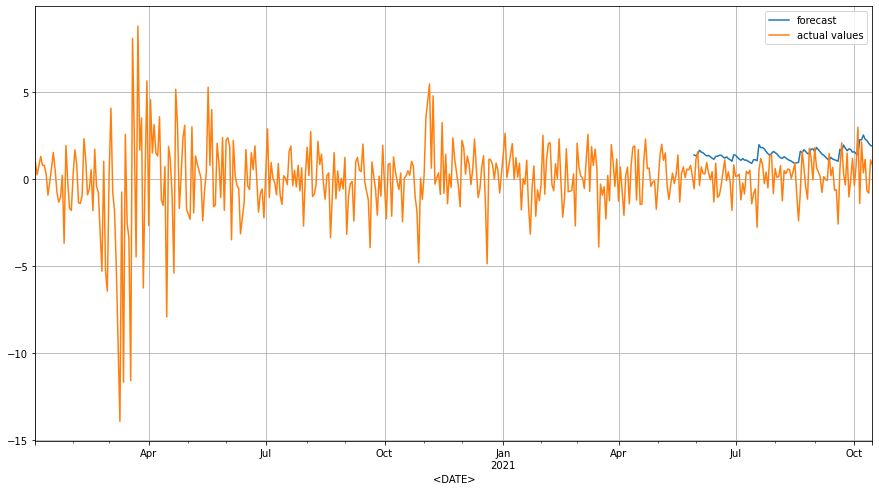

In [111]:
fvm.hist_output.plot(label='forecast', figsize=(15, 8))
input_data.plot(label='actual values')

plt.legend()
plt.grid()
plt.show()

##### Errors

In [112]:
mean_squared_error(fvm.hist_output, test, squared=True)

2.5808119877168767466

In [113]:
mean_squared_error(fvm.hist_output, test, squared=False)

1.6064905812723822959

In [114]:
mean_absolute_percentage_error(fvm.hist_output, test)

0.9764997116773164773